# Data pre-processing and model creation, training, testing and saving

In [ ]:
!pip install datasets torchinfo torchmetrics piqa pytorch-msssim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# !mkdir 'utils'

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy
import numpy as np
import time
from tqdm.auto import tqdm
import cv2
import torchvision
import torchvision.transforms.functional as TF
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision.datasets import DatasetFolder
from torchmetrics import StructuralSimilarityIndexMeasure, PeakSignalNoiseRatio
from datasets import load_dataset
import math
from torch.utils.data import DataLoader
import PIL
from PIL import Image
from skimage.metrics import structural_similarity
import random
from typing import List, Dict, Tuple
from torchinfo import summary
import os
import shutil
import tempfile
import urllib.request
import zipfile

### Using GPU if its available (device agnostic)

In [ ]:
!nvidia-smi

Tue Apr  4 16:58:42 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
torch.cuda.is_available()

True

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


## Function to load images and return them as torch.tensor

In [ ]:
image_transforms = transforms.Compose([
      transforms.Resize(size=(224, 224)),
      transforms.ToTensor()
  ])

def load_images(dir: List[str], transforms: torchvision.transforms.Compose = image_transforms):
  images = []

  for file in tqdm(dir, unit="images"):
    with Image.open(file) as img:
      img = transforms(img).numpy()
      if(img.shape[0] == 3):
          images.append(img)
  return torch.from_numpy(np.array(images))

## Downloading the Set14 + Set5 images

In [ ]:
set14 = load_dataset('eugenesiow/Set14')
set5 = load_dataset('eugenesiow/Set5')

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
images_dir = set14['validation']['hr'] + set5['validation']['hr']
len(images_dir)

19

## Train-Test split

In [ ]:
test_size = 0.25
train_size = 1 - test_size
random.seed(42)
train_dir = random.sample(images_dir, k = math.ceil(len(images_dir)*train_size))
test_dir = random.sample(images_dir, k = math.floor(len(images_dir)*test_size))

len(train_dir), len(test_dir)

(15, 4)

In [ ]:
test_dir

['/root/.cache/huggingface/datasets/downloads/extracted/74079e4460748b906893e2599eba2c932cc8d3460e3b9555083d7081d5301194/Set14_HR/flowers.png',
 '/root/.cache/huggingface/datasets/downloads/extracted/74079e4460748b906893e2599eba2c932cc8d3460e3b9555083d7081d5301194/Set14_HR/foreman.png',
 '/root/.cache/huggingface/datasets/downloads/extracted/0ddd43918bcf04db71a20394d1da24153293e6baf29f66ad0dbece31bc89e0f8/Set5_HR/butterfly.png',
 '/root/.cache/huggingface/datasets/downloads/extracted/74079e4460748b906893e2599eba2c932cc8d3460e3b9555083d7081d5301194/Set14_HR/baboon.png']

In [ ]:
train_images = load_images(train_dir)
test_images = load_images(test_dir)
train_images.shape, test_images.shape

  0%|          | 0/15 [00:00<?, ?images/s]

  0%|          | 0/4 [00:00<?, ?images/s]

(torch.Size([14, 3, 224, 224]), torch.Size([4, 3, 224, 224]))

(-0.5, 223.5, 223.5, -0.5)

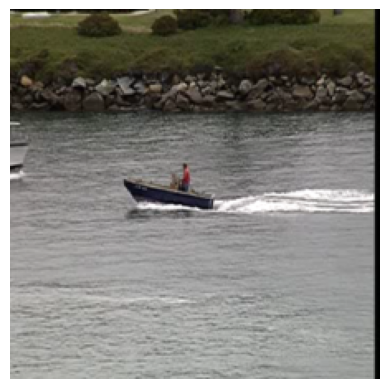

In [ ]:
plt.imshow(train_images[0].permute(1,2,0).numpy())
plt.axis(False)

## Function to extract random patches and apply gamma to darken them

In [ ]:
# %%writefile utils/extract_patches.py
import numpy as np
import torch
import torchvision.transforms.functional as TF
from tqdm.auto import tqdm
import random

def extract_patches(images, patch_size=17, num_patches=2500, random_seed=42):
  random.seed(random_seed)
  torch.manual_seed(random_seed)
  torch.cuda.manual_seed(random_seed)
  # Convert the pytorch tensor to a numpy array in (N x H x W x C)
  image_array = (images.permute(0,2,3,1)*255).numpy().astype('uint8')

  # Get the number of images and the height and width of each image
  num_images, height, width, channels = image_array.shape

  # Initialize empty lists to store the patches and their gamma-adjusted versions
  patches = []
  gamma_patches = []

  # Loop over the images
  for i in tqdm(range(num_images), unit="images"):
      # Extract the i-th image
      image = image_array[i]

      # Extract the patches
      for j in range(num_patches):
          # Generate a random location to extract the patch from
          x = np.random.randint(0, width - patch_size)
          y = np.random.randint(0, height - patch_size)

          # Extract the patch
          patch = image[y:y+patch_size, x:x+patch_size]

          # Set a random gamma value between 2 and 5 to darken the patch
          gamma = np.random.uniform(2, 5)

          # Convert the patch to a PIL image
          patch_pil = TF.to_pil_image(patch)

          # Apply gamma correction to the patch
          gamma_patch_pil = TF.adjust_gamma(patch_pil, gamma)

          # Convert the patches back to numpy arrays
          patch = np.array(patch_pil)
          gamma_patch = np.array(gamma_patch_pil)

          # Add the patches to the lists
          patches.append(patch)
          gamma_patches.append(gamma_patch)

  # Convert the lists of patches to pytorch tensors
  patches_tensor = torch.from_numpy(np.array(patches)).permute(0,3,1,2) # Back to N x C x H x W
  gamma_patches_tensor = torch.from_numpy(np.array(gamma_patches)).permute(0,3,1,2)

  return (gamma_patches_tensor, patches_tensor)


## Function to plot two images to compare

In [ ]:
# %%writefile utils/compare_plot.py
import matplotlib.pyplot as plt
def compare_plot(X, y):
  fig, axes = plt.subplots(1,2)
  axes[0].imshow(X)
  axes[0].axis(False)
  axes[1].imshow(y)
  axes[1].axis(False)

In [ ]:
X_train, y_train = extract_patches(train_images)
X_test, y_test = extract_patches(test_images)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

  0%|          | 0/14 [00:00<?, ?images/s]

  0%|          | 0/4 [00:00<?, ?images/s]

(torch.Size([35000, 3, 17, 17]),
 torch.Size([35000, 3, 17, 17]),
 torch.Size([10000, 3, 17, 17]),
 torch.Size([10000, 3, 17, 17]))

Darkened vs Ground Truth


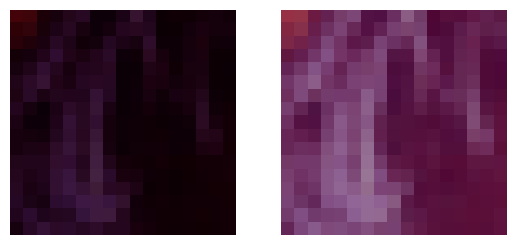

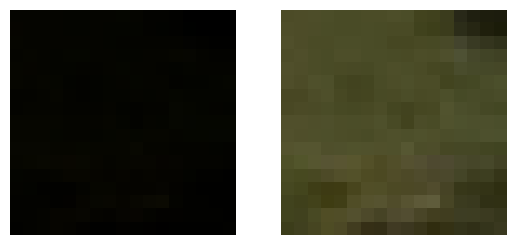

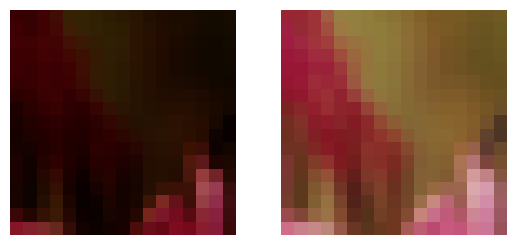

In [ ]:
# Plotting 3 random samples from training set
print("Darkened vs Ground Truth")
for i in range(3):
  idx = random.randint(0, len(X_train))
  compare_plot(X_train[idx].permute(1,2,0), y_train[idx].permute(1,2,0))

## Creating Dataset and DataLoader

In [ ]:
# %%writefile going_modular/data_setup.py
"""
Contains the functionality for downloading, processing and creating dataloaders for the models
"""

import os

from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader

# NUM_WORKERS = os.cpu_count()
NUM_WORKERS = 0 # Mutliprocessing glitch in notebooks, so using 0

class ImagePatchesCustom(Dataset):

  def __init__(self, X, y, transforms=None):
    self.X = X
    self.y = y
    self.transforms = transforms

  def __len__(self) -> int:
    return len(self.y)

  def __getitem__(self, idx: int) -> Tuple[torch.Tensor]:
    if self.transforms:
      return (self.transforms(self.X[idx]), self.transforms(self.y[idx]))
    return (self.X[idx], self.y[idx])

def create_dataloaders(
    train_dir: str,
    test_dir: str,
    train_transforms: transforms.Compose,
    test_transforms: transforms.Compose,
    batch_size: int=32,
    num_workers: int=NUM_WORKERS,
    patch_size=17,
    num_patches=2500
):
  """Creates training and testing DataLoaders.

  Takes in a training directory and testing directory path and turns
  them into PyTorch Datasets and then into PyTorch DataLoaders.

  Args:
    train_dir: Path to training directory.
    test_dir: Path to testing directory.
    transform: torchvision transforms to perform on training and testing data.
    batch_size: Number of samples per batch in each of the DataLoaders.
    num_workers: An integer for number of workers per DataLoader.

  Returns:
    A tuple of (train_dataloader, test_dataloader).
  """


  print("Loading train images...")
  train_imgs = load_images(train_dir)
  print("Loading test images...")
  test_imgs = load_images(test_dir)
  print("Extracting random patches from training images...")
  X_train, y_train = extract_patches(train_imgs, patch_size=patch_size, num_patches=num_patches)
  print("Extracting random patches from testing images...")
  X_test, y_test = extract_patches(test_imgs, patch_size=patch_size, num_patches=num_patches)
  train_data = ImagePatchesCustom(X_train, y_train, transforms=train_transforms)
  test_data = ImagePatchesCustom(X_test, y_test, transforms=test_transforms)

  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader

In [ ]:
train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    # transforms.Resize(size=(224, 224)),
    transforms.ToTensor()
])
test_transforms = transforms.Compose([
    transforms.ToPILImage(),
    # transforms.Resize(size=(224, 224)),
    transforms.ToTensor()
])

train_dataloader, test_dataloader = create_dataloaders(train_dir, test_dir, train_transforms, test_transforms)

Loading train images...


  0%|          | 0/15 [00:00<?, ?images/s]

Loading test images...


  0%|          | 0/4 [00:00<?, ?images/s]

Extracting random patches from training images...


  0%|          | 0/14 [00:00<?, ?images/s]

Extracting random patches from testing images...


  0%|          | 0/4 [00:00<?, ?images/s]

In [ ]:
print(f"# of training batches: {len(train_dataloader)}")
print(f"# of testing batches: {len(test_dataloader)}")

# of training batches: 1094
# of testing batches: 313


## Defining the loss function

In [ ]:
def loss_fn(img1, img2):
    """
    Computes the SSIM loss between two images.
    """
    # Compute the mean of the images
    mu1 = F.avg_pool2d(img1, kernel_size=8, stride=1, padding=0)
    mu2 = F.avg_pool2d(img2, kernel_size=8, stride=1, padding=0)

    # Compute the variance of the images
    sigma1 = F.avg_pool2d(img1 ** 2, kernel_size=8, stride=1, padding=0) - mu1 ** 2
    sigma2 = F.avg_pool2d(img2 ** 2, kernel_size=8, stride=1, padding=0) - mu2 ** 2

    # Compute the covariance between the images
    sigma12 = F.avg_pool2d(img1 * img2, kernel_size=8, stride=1, padding=0) - mu1 * mu2

    # Compute the SSIM
    C1 = 0.0001
    C2 = 0.001
    ssim = (2 * mu1 * mu2 + C1) * (2 * sigma12 + C2) / ((mu1 ** 2 + mu2 ** 2 + C1) * (sigma1 + sigma2 + C2))

    # Return the negative SSIM as a loss
    return 1 - ssim.mean()

torch.manual_seed(42)
torch.cuda.manual_seed(42)
img1 = torch.rand(1, 3, 17, 17).to(device)
img2 = torch.rand(1, 3, 17, 17).to(device)
loss_fn(img1, img2)

tensor(1.0088, device='cuda:0')

In [ ]:
class CustomLoss(nn.Module):
    def __init__(self, device=None):
        super(CustomLoss, self).__init__()
        if device == None:
          device = "cuda" if torch.cuda.is_available() else "cpu"
        self.ssim = StructuralSimilarityIndexMeasure(data_range=1.0, kernel_size=7, k1=0.0001, k2=0.001, reduction='elementwise_mean').to(device)

    def forward(self, pred, target):
        ssim_score = self.ssim(pred, target)
        loss = 1.0 - ssim_score
        return loss

torch.manual_seed(42)
torch.cuda.manual_seed(42)
img1 = torch.rand(1, 3, 17, 17).to(device)
img2 = torch.rand(1, 3, 17, 17).to(device)
CustomLoss()(img1, img2)

tensor(1.0470, device='cuda:0')

# Defining the model

In [ ]:
class ConvModule(nn.Module):
  def __init__(self, n_filters=64):
    super(ConvModule, self).__init__()
    self.n_filters = n_filters

    # Stage-1
    self.conv1_1 = nn.Conv2d(in_channels=n_filters, out_channels=n_filters, kernel_size=1, padding='same', stride=1) # Single 1x1 : Padding = 0
    self.conv1_2 = nn.Conv2d(n_filters, n_filters, kernel_size=3, padding='same', stride=1) # First layer of two 3x3 : Padding = 1 for the rest
    self.conv1_3 = nn.Conv2d(n_filters, n_filters, kernel_size=3, padding='same', stride=1) # Second layer of two 3x3

    # Stage-2
    self.conv2_1 = nn.Conv2d(n_filters, n_filters, kernel_size=3, padding='same', stride=1) # First 3x3
    self.conv2_2 = nn.Conv2d(n_filters, n_filters, kernel_size=3, padding='same', stride=1) # Second 3x3

    self.add_residue = lambda x: x[0] + x[1]

    self.relu = nn.ReLU()

  def forward(self, x):
    # 1x1
    way1 = self.conv1_1(x)
    # 3x3
    way2 = self.conv1_2(x)
    way2 = self.relu(way2)
    way2 = self.conv1_3(way2)

    # Adding output of stage-1
    residue = self.add_residue([way1, way2])

    # Stage-2
    x = self.relu(residue)
    x = self.conv2_1(x)
    x = self.relu(x)
    x = self.conv2_2(x)

    # Adding residue of stage-1 with output of stage-2
    x = self.add_residue([x, residue])
    out = self.relu(x)
    return out

In [ ]:
class LLCNN(nn.Module):
  def __init__(self, channels=3, blocks=3):
    super(LLCNN, self).__init__()

    self.conv1 = nn.Conv2d(in_channels=channels, out_channels=64, kernel_size=3, padding='same', stride=1)
    self.relu = nn.ReLU()
    self.conv_modules = nn.Sequential(*[ConvModule() for _ in range(blocks)])

    self.conv2 = nn.Conv2d(64, channels, kernel_size=1, padding=0, stride=1)

  def forward(self, x):
    x = self.conv1(x)
    x = self.relu(x)
    x = self.conv_modules(x)
    out = self.conv2(x)
    return out

In [ ]:
class SEConvModule(nn.Module):
  def __init__(self, n_filters=64, r=16):
    super(SEConvModule, self).__init__()
    self.n_filters = n_filters

    # Stage-1
    self.conv1_1 = nn.Conv2d(in_channels=n_filters, out_channels=n_filters, kernel_size=1, padding='same', stride=1) # Single 1x1 : Padding 0
    self.conv1_2 = nn.Conv2d(n_filters, n_filters, kernel_size=3, padding='same', stride=1) # First layer of two 3x3 : Padding 1 for the rest
    self.conv1_3 = nn.Conv2d(n_filters, n_filters, kernel_size=3, padding='same', stride=1) # Second layer of two 3x3

    # Stage-2
    self.conv2_1 = nn.Conv2d(n_filters, n_filters, kernel_size=3, padding='same', stride=1) # First 3x3
    self.conv2_2 = nn.Conv2d(n_filters, n_filters, kernel_size=3, padding='same', stride=1) # Second 3x3

    # New SE Block
    self.se = torchvision.ops.SqueezeExcitation(n_filters, r)

    self.add_residue = lambda x: x[0] + x[1]

    self.relu = nn.ReLU()

  def forward(self, x):
    # 1x1
    way1 = self.conv1_1(x)
    # 3x3
    way2 = self.conv1_3(self.relu(self.conv1_2(x)))

    # Adding output of stage-1
    residue = self.add_residue([way1, way2])

    # Stage-2
    # Adding residue of stage-1 with output of stage-2
    x = self.relu(residue)
    x = self.conv2_1(x)
    x = self.relu(x)
    x = self.conv2_2(x)
    x = self.add_residue([x, residue])
    x = self.se(x)
    x = self.relu(x)

    return x
    # return self.relu(self.se(self.add_residue([self.conv2_2(self.relu(self.conv2_1(self.relu(residue)))), residue])))

In [ ]:
class SELLCNN(nn.Module):
  def __init__(self, channels=3, se_blocks=3, blocks=3):
    super(SELLCNN, self).__init__()

    self.conv1 = nn.Conv2d(in_channels=channels, out_channels=64, kernel_size=3, padding='same', stride=1)
    self.relu = nn.ReLU()
    self.tanh = nn.Tanh()
    self.conv_modules = nn.Sequential(*[SEConvModule() for _ in range(se_blocks)])
    self.conv_modules_2 = nn.Sequential(*[ConvModule() for _ in range(blocks)])

    self.conv2 = nn.Conv2d(64, channels, kernel_size=1, padding=0, stride=1)

  def forward(self, x):
    x = self.conv1(x)
    x = self.relu(x)
    x = self.conv_modules(x)
    x = self.conv_modules_2(x)
    x = self.conv2(x)
    # x = self.tanh(x)

    return x
    # return self.conv2(self.conv_modules_2(self.conv_modules(self.relu(self.conv1(x)))))

## Creating the model, preparing the data and the optimizer

In [ ]:
# model_se = LLCNN().to(device)
model_se = SELLCNN(se_blocks=3, blocks=0).to(device)

In [ ]:
summary(model_se, [1,3,17,17])

Layer (type:depth-idx)                        Output Shape              Param #
SELLCNN                                       [1, 3, 17, 17]            --
├─Conv2d: 1-1                                 [1, 64, 17, 17]           1,792
├─ReLU: 1-2                                   [1, 64, 17, 17]           --
├─Sequential: 1-3                             [1, 64, 17, 17]           --
│    └─SEConvModule: 2-1                      [1, 64, 17, 17]           --
│    │    └─Conv2d: 3-1                       [1, 64, 17, 17]           4,160
│    │    └─Conv2d: 3-2                       [1, 64, 17, 17]           36,928
│    │    └─ReLU: 3-3                         [1, 64, 17, 17]           --
│    │    └─Conv2d: 3-4                       [1, 64, 17, 17]           36,928
│    │    └─ReLU: 3-5                         [1, 64, 17, 17]           --
│    │    └─Conv2d: 3-6                       [1, 64, 17, 17]           36,928
│    │    └─ReLU: 3-7                         [1, 64, 17, 17]           --
│ 

In [ ]:
se_optimizer = torch.optim.SGD(model_se.parameters(), momentum=0.9, weight_decay=0.0001, lr=0.01)

In [ ]:
# result = train(model_se, train_dataloader, test_dataloader, se_optimizer, loss_fn, 30, device)

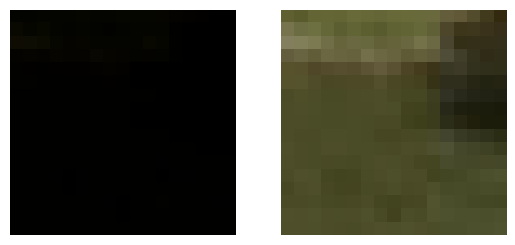

In [ ]:
compare_plot(X_train[0].cpu().permute(1,2,0), y_train[0].cpu().permute(1,2,0))

In [ ]:
# import gc
# gc.collect()
# torch.cuda.empty_cache()

# from numba import cuda
# gpu = cuda.get_current_device()
# gpu.reset()

In [ ]:
epochs = 15

torch.manual_seed(42)
torch.cuda.manual_seed(42)

train_loss = []
val_loss = []

# loss_fn = CustomLoss()

model_se = model_se.to(device)
for epoch in range(epochs):
  print(f"Epoch {epoch+1}/{epochs}...")
  running_loss = 0.
  last_loss = 0.
  i = 0
  with tqdm(train_dataloader, unit="batch") as tepoch:
    model_se = model_se.to(device)
    model_se.train()
    for X_batch, y_batch in tepoch:
      # Reset prev grads
      se_optimizer.zero_grad()

      # print(X_batch.shape, y_batch.shape)
      X_batch, y_batch = X_batch.to(device), y_batch.to(device)
      i += 1

      # Predict
      y_pred = model_se(X_batch)
      # Calc SSIM loss
      loss = loss_fn(y_pred, y_batch)

      # Calc SSIM loss's backprop
      loss.backward()

      loss = loss.item()

      # Back prop
      se_optimizer.step()

      running_loss += loss
      last_loss = running_loss / len(X_batch) # loss per batch
      running_loss = 0.
  model_se.eval()
  running_vloss = 0.0
  for i, vdata in enumerate(test_dataloader):
    vinputs, vlabels = vdata
    vinputs, vlabels = vinputs.to(device), vlabels.to(device)
    voutputs = model_se(vinputs)
    vloss = loss_fn(voutputs, vlabels)
    running_vloss += vloss.item()

  avg_loss = last_loss
  avg_vloss = running_vloss / (i + 1)
  train_loss.append(avg_loss)
  val_loss.append(avg_vloss)
  print('Epoch-{}\'s train loss: {}, validation loss: {}'.format(epoch+1, avg_loss, avg_vloss))

Epoch 1/15...


  0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch-1's train loss: 0.00736012061436971, validation loss: 0.13467659984533778
Epoch 2/15...


  0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch-2's train loss: 0.00476676474014918, validation loss: 0.10800206280364015
Epoch 3/15...


  0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch-3's train loss: 0.0025547618667284646, validation loss: 0.08823714431482382
Epoch 4/15...


  0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch-4's train loss: 0.00412438561518987, validation loss: 0.09519890760080502
Epoch 5/15...


  0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch-5's train loss: 0.002057120203971863, validation loss: 0.07950019684081641
Epoch 6/15...


  0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch-6's train loss: 0.007139421999454498, validation loss: 0.0756110651805378
Epoch 7/15...


  0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch-7's train loss: 0.004527101914087932, validation loss: 0.08472917674067683
Epoch 8/15...


  0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch-8's train loss: 0.004050041238466899, validation loss: 0.07695311860154612
Epoch 9/15...


  0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch-9's train loss: 0.0026206225156784058, validation loss: 0.0814490141198277
Epoch 10/15...


  0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch-10's train loss: 0.0060106391708056135, validation loss: 0.09306360414614692
Epoch 11/15...


  0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch-11's train loss: 0.002820757528146108, validation loss: 0.06850629606947731
Epoch 12/15...


  0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch-12's train loss: 0.004081616799036662, validation loss: 0.07263407120689416
Epoch 13/15...


  0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch-13's train loss: 0.0060235485434532166, validation loss: 0.07309681672257737
Epoch 14/15...


  0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch-14's train loss: 0.003176709016164144, validation loss: 0.06928150132060432
Epoch 15/15...


  0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch-15's train loss: 0.003685551385084788, validation loss: 0.07376334918573642


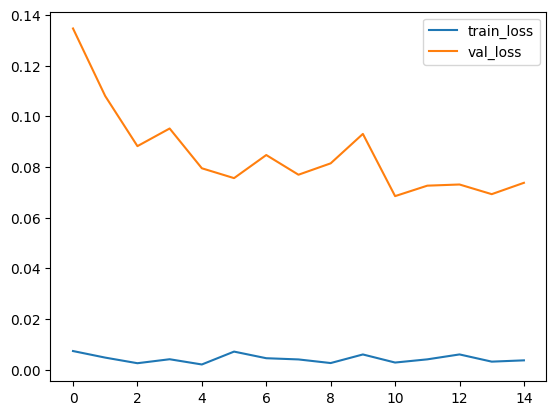

In [ ]:
plt.plot(train_loss, label='train_loss')
plt.plot(val_loss, label='val_loss')
plt.legend()
plt.show()

In [ ]:
torch.save({
            'model_state_dict': model_se.state_dict(),
            'optimizer_state_dict': se_optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss
            }, '/content/drive/MyDrive/DL/SELLCNN_3_0.pth')

In [ ]:
torch.load("/content/drive/MyDrive/DL/SELLCNN_3_3.pth")["model_state_dict"].keys()

odict_keys(['conv1.weight', 'conv1.bias', 'conv_modules.0.conv1_1.weight', 'conv_modules.0.conv1_1.bias', 'conv_modules.0.conv1_2.weight', 'conv_modules.0.conv1_2.bias', 'conv_modules.0.conv1_3.weight', 'conv_modules.0.conv1_3.bias', 'conv_modules.0.conv2_1.weight', 'conv_modules.0.conv2_1.bias', 'conv_modules.0.conv2_2.weight', 'conv_modules.0.conv2_2.bias', 'conv_modules.0.se.fc1.weight', 'conv_modules.0.se.fc1.bias', 'conv_modules.0.se.fc2.weight', 'conv_modules.0.se.fc2.bias', 'conv_modules_2.0.conv1_1.weight', 'conv_modules_2.0.conv1_1.bias', 'conv_modules_2.0.conv1_2.weight', 'conv_modules_2.0.conv1_2.bias', 'conv_modules_2.0.conv1_3.weight', 'conv_modules_2.0.conv1_3.bias', 'conv_modules_2.0.conv2_1.weight', 'conv_modules_2.0.conv2_1.bias', 'conv_modules_2.0.conv2_2.weight', 'conv_modules_2.0.conv2_2.bias', 'conv_modules_2.1.conv1_1.weight', 'conv_modules_2.1.conv1_1.bias', 'conv_modules_2.1.conv1_2.weight', 'conv_modules_2.1.conv1_2.bias', 'conv_modules_2.1.conv1_3.weight', 'co

In [ ]:
model_se = SELLCNN(se_blocks=1, blocks=2).to(device)
model_se.load_state_dict(torch.load("/content/drive/MyDrive/DL/SELLCNN_new.pth")["model_state_dict"])

<All keys matched successfully>

In [ ]:
idx = 16
X_test = X_test.to(device)
sample = train_transforms(X_test[idx]).to(device)
model_se.eval()
output = model_se(sample.unsqueeze(0)).cpu().detach().squeeze()
sample = sample.cpu()
# compare_plot(sample.permute(1,2,0), y_test[idx].permute(1,2,0))
# compare_plot(sample.permute(1,2,0), output.permute(1,2,0))

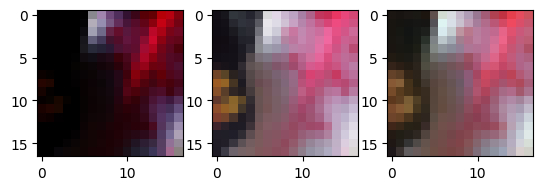

In [ ]:
fig, axes = plt.subplots(1, 3)
axes[0].imshow(X_test[idx].cpu().permute(1,2,0))
axes[1].imshow(y_test[idx].cpu().permute(1,2,0))
axes[2].imshow(output.cpu().permute(1,2,0).detach().numpy())

In [ ]:
print("SSIM: ", 1-loss_fn(output, y_test[idx]/255).item())

SSIM:  0.9555622339248657


In [ ]:
model = LLCNN()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
summary(model)

Layer (type:depth-idx)                   Param #
LLCNN                                    --
├─Conv2d: 1-1                            1,792
├─ReLU: 1-2                              --
├─Sequential: 1-3                        --
│    └─ConvModule: 2-1                   --
│    │    └─Conv2d: 3-1                  4,160
│    │    └─Conv2d: 3-2                  36,928
│    │    └─Conv2d: 3-3                  36,928
│    │    └─Conv2d: 3-4                  36,928
│    │    └─Conv2d: 3-5                  36,928
│    │    └─ReLU: 3-6                    --
│    └─ConvModule: 2-2                   --
│    │    └─Conv2d: 3-7                  4,160
│    │    └─Conv2d: 3-8                  36,928
│    │    └─Conv2d: 3-9                  36,928
│    │    └─Conv2d: 3-10                 36,928
│    │    └─Conv2d: 3-11                 36,928
│    │    └─ReLU: 3-12                   --
│    └─ConvModule: 2-3                   --
│    │    └─Conv2d: 3-13                 4,160
│    │    └─Conv2d: 3-14   

In [ ]:
model.load_state_dict(torch.load("/content/drive/MyDrive/DL/LLCNN.pth")["model_state_dict"])

<All keys matched successfully>

In [ ]:
model.eval()
output = model(sample.unsqueeze(0)).cpu().detach().squeeze()
sample = sample.cpu()
compare_plot(sample.permute(1,2,0), y_test[idx].permute(1,2,0))
compare_plot(sample.permute(1,2,0), output.permute(1,2,0))

NameError: ignored

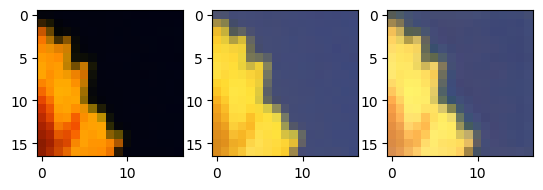

In [ ]:
fig, axes = plt.subplots(1, 3)
axes[0].imshow(X_test[idx].cpu().permute(1,2,0))
axes[1].imshow(y_test[idx].cpu().permute(1,2,0))
axes[2].imshow(output.cpu().permute(1,2,0).detach().numpy())

In [ ]:
print("SSIM: ", 1-loss_fn(output, y_test[idx]/255).item())

SSIM:  0.8875755667686462


In [ ]:
def download_from_source(url: str, filename: str = None) -> str:
  print("Downloading...")
  # Create a temporary directory to store the downloaded zip file and its contents
  with tempfile.TemporaryDirectory() as tmpdir:
    # Download the zip file to the temporary directory
    zip_path, _ = urllib.request.urlretrieve(url, os.path.join(tmpdir, "download.zip"))

    # Get the filename for the extracted directory
    if filename is None:
      filename = os.path.splitext(os.path.basename(zip_path))[0]

    # Extract the zip file to the current directory
    with zipfile.ZipFile(zip_path, "r") as zip_file:
      zip_file.extractall(filename)

    # Return the path to the directory containing the extracted files
    return os.path.abspath(filename)

In [ ]:
downloaded = download_from_source("http://cv.snu.ac.kr/research/VDSR/train_data.zip", "VDSR")
downloaded

Downloading...


'/content/VDSR'

In [ ]:
def load_images_as_tensor(folder_path: str, sub_folder: str = None, transform: torchvision.transforms = None) -> torch.Tensor:
  if sub_folder:
    folder_path = os.path.join(folder_path, sub_folder)

  # Load the images from the folder as a dataset, with each class/subfolder determined by the first part of the file name
  dataset = datasets.DatasetFolder(folder_path, loader=torchvision.datasets.folder.default_loader, extensions=('jpg', 'jpeg', 'png', 'bmp'), transform=transform)

  # Create a dataloader from the dataset
  dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False)

  # Create a dictionary to store the image tensors for each class/subfolder
  images_by_class = {}

  # Loop over the dataloader and append each image tensor to the dictionary for the appropriate class/subfolder
  for batch in dataloader:
      image = batch[0]
      label = dataset.classes[batch[1]]

      if label not in images_by_class:
          images_by_class[label] = []

      images_by_class[label].append(image)

  # Return the dictionary of image tensors by class/subfolder
  return images_by_class

In [ ]:
loaded = load_images_as_tensor(downloaded, transform=image_transforms)

In [ ]:
datas = loaded['291']

In [ ]:
loaded['291'][0].shape

torch.Size([1, 3, 224, 224])

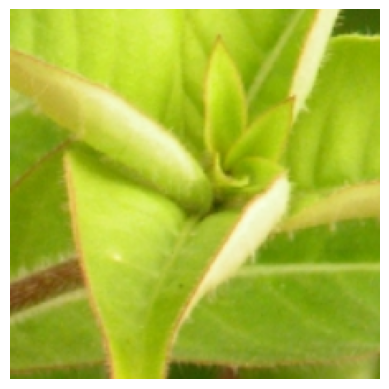

In [ ]:
plt.imshow(loaded['291'][7].squeeze().permute(1,2,0))
plt.axis(False)
plt.show()

In [ ]:
vdsr_images_dir = []
for root, dirs, files in os.walk(os.path.join(downloaded, "291")):
  for file in files:
    vdsr_images_dir.append(os.path.join(root, file))
len(vdsr_images_dir)

291

In [ ]:
random.seed(42)
train_dir = vdsr_images_dir
test_dir = images_dir

len(train_dir), len(test_dir)

(291, 19)

In [ ]:
train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    # transforms.Resize(size=(224, 224)),
    transforms.ToTensor()
])
test_transforms = transforms.Compose([
    transforms.ToPILImage(),
    # transforms.Resize(size=(224, 224)),
    transforms.ToTensor()
])

train_dataloader, test_dataloader = create_dataloaders(train_dir, test_dir, train_transforms, test_transforms, patch_size=41, num_patches=1500)

Loading train images...


  0%|          | 0/291 [00:00<?, ?images/s]

Loading test images...


  0%|          | 0/19 [00:00<?, ?images/s]

Extracting random patches from training images...


  0%|          | 0/291 [00:00<?, ?images/s]

Extracting random patches from testing images...


  0%|          | 0/18 [00:00<?, ?images/s]

In [ ]:
model_se = SELLCNN(se_blocks=3, blocks=0).to(device)
summary(model_se, [1,3,41,41])

Layer (type:depth-idx)                        Output Shape              Param #
SELLCNN                                       [1, 3, 41, 41]            --
├─Conv2d: 1-1                                 [1, 64, 41, 41]           1,792
├─ReLU: 1-2                                   [1, 64, 41, 41]           --
├─Sequential: 1-3                             [1, 64, 41, 41]           --
│    └─SEConvModule: 2-1                      [1, 64, 41, 41]           --
│    │    └─Conv2d: 3-1                       [1, 64, 41, 41]           4,160
│    │    └─Conv2d: 3-2                       [1, 64, 41, 41]           36,928
│    │    └─ReLU: 3-3                         [1, 64, 41, 41]           --
│    │    └─Conv2d: 3-4                       [1, 64, 41, 41]           36,928
│    │    └─ReLU: 3-5                         [1, 64, 41, 41]           --
│    │    └─Conv2d: 3-6                       [1, 64, 41, 41]           36,928
│    │    └─ReLU: 3-7                         [1, 64, 41, 41]           --
│ 

In [ ]:
model_se.load_state_dict(torch.load("/content/drive/MyDrive/DL/SELLCNN_3_0_vdsr.pth")["model_state_dict"])

<All keys matched successfully>

In [ ]:
se_optimizer = torch.optim.SGD(model_se.parameters(), momentum=0.9, weight_decay=0.0001, lr=0.01)
se_optimizer.load_state_dict(torch.load("/content/drive/MyDrive/DL/SELLCNN_3_0_vdsr.pth")["optimizer_state_dict"])
epochs = 10

torch.manual_seed(42)
torch.cuda.manual_seed(42)

train_loss = []
train_loss = torch.load("/content/drive/MyDrive/DL/SELLCNN_3_0_vdsr.pth")["train_loss"]
val_loss = []
val_loss = torch.load("/content/drive/MyDrive/DL/SELLCNN_3_0_vdsr.pth")["val_loss"]
print(train_loss)
print(val_loss)

# loss_fn = CustomLoss()

model_se = model_se.to(device)
for epoch in range(epochs):
  print(f"Epoch {epoch+1}/{epochs}...")
  running_loss = 0.
  last_loss = 0.
  i = 0
  with tqdm(train_dataloader, unit="batch") as tepoch:
    model_se = model_se.to(device)
    model_se.train()
    for X_batch, y_batch in tepoch:
      # Reset prev grads
      se_optimizer.zero_grad()

      # print(X_batch.shape, y_batch.shape)
      X_batch, y_batch = X_batch.to(device), y_batch.to(device)
      i += 1

      # Predict
      y_pred = model_se(X_batch)
      # Calc SSIM loss
      loss = loss_fn(y_pred, y_batch)

      # Calc SSIM loss's backprop
      loss.backward()

      loss = loss.item()

      # Back prop
      se_optimizer.step()

      running_loss += loss
      last_loss = running_loss / len(X_batch) # loss per batch
      running_loss = 0.
  model_se.eval()
  running_vloss = 0.0
  for i, vdata in enumerate(test_dataloader):
    vinputs, vlabels = vdata
    vinputs, vlabels = vinputs.to(device), vlabels.to(device)
    voutputs = model_se(vinputs)
    vloss = loss_fn(voutputs, vlabels)
    running_vloss += vloss.item()

  avg_loss = last_loss
  avg_vloss = running_vloss / (i + 1)
  train_loss.append(avg_loss)
  val_loss.append(avg_vloss)
  print('Epoch-{}\'s train loss: {}, validation loss: {}'.format(epoch+1, avg_loss, avg_vloss))

[0.0036668241024017333, 0.0051924437284469604, 0.003292378783226013, 0.003462502360343933, 0.0035984545946121218]
[0.0968085170780878, 0.09769758073639531, 0.09325404670001207, 0.0904433348732537, 0.09206838814003207]
Epoch 1/10...


  0%|          | 0/13641 [00:00<?, ?batch/s]

In [ ]:
plt.plot(train_loss, label='train_loss')
plt.plot(val_loss, label='val_loss')
plt.legend()
plt.show()

In [ ]:
torch.save({
            'model_state_dict': model_se.state_dict(),
            'optimizer_state_dict': se_optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss
            }, '/content/drive/MyDrive/DL/SELLCNN_3_0_vdsr_15e.pth')